In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,'../st_validate')
sys.path.insert(0,'../periodic-kmeans')

import os
import tifffile
import numpy as np
import warnings
import matplotlib.pyplot as plt
np.warnings = warnings # this line is necessary to suppress an error produced by the default np.warnings
import sta_validate # import functions for phantom creation and sta tests
import histology # import functions for computing structure tensors and angles
import apsym_kmeans # import functions for angle clustering in 3D
import periodic_kmeans # import functions for angle clustering in 2D
import utils

HOME = "/home/brysongray/structure_tensor_validation/"


# Generate a 3D phantom

## Set the phantom parameters

In [4]:
# load presaved angles from file
angles = np.load('../3d_angles.npy')

# choose a random pair of directions from angles
idx = np.random.randint(0,len(angles), size=2)
true_angles = np.stack((angles[idx[0]], angles[idx[1]]))

# or a single random direction from angles
# true_angles = np.array([angles[idx[0]]])
print(f'angle: {true_angles}')

# set the image dimensions
shape = (36,72,72)
dI = (shape[1]/shape[0], 1.0, 1.0) # size of pixels along each dimension
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# period is the distance between parallel lines in units
# relative to the pixel size along the high resolution dimensions.
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

angle: [[1.09650466 0.15863289]
 [1.7943213  0.86972032]]


## Generate the phantom and do anisotropy correction

In [5]:
# generate phantom with anisotropic pixel sizes
image_3d = sta_validate.make_phantom(x, true_angles, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_3d = utils.anisotropy_correction(image_3d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_3d = utils.anisotropy_correction(image_3d, dI=dI, blur=True)

## Visualize

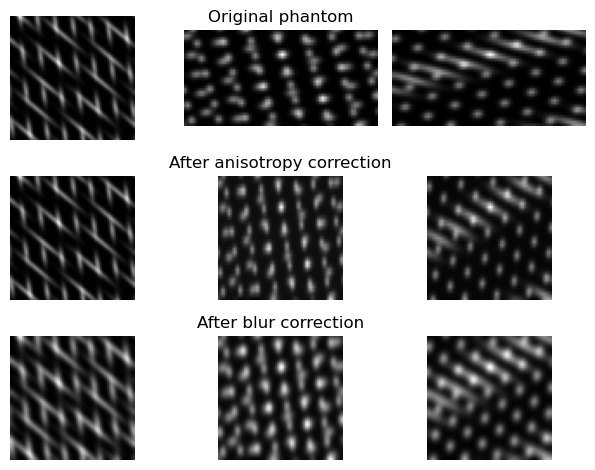

In [6]:
fig, ax = plt.subplots(3,3, tight_layout=True)

ax[0,0].imshow(image_3d[image_3d.shape[0]//2], cmap='gray')
ax[0,1].imshow(image_3d[:, image_3d.shape[1]//2], cmap='gray')
ax[0,1].set_title('Original phantom')
ax[0,2].imshow(image_3d[..., image_3d.shape[2]//2], cmap='gray')
ax[1,0].imshow(image_iso_3d[image_iso_3d.shape[0]//2], cmap='gray')
ax[1,1].imshow(image_iso_3d[:, image_iso_3d.shape[1]//2], cmap='gray')
ax[1,1].set_title('After anisotropy correction')
ax[1,2].imshow(image_iso_3d[..., image_iso_3d.shape[2]//2], cmap='gray')
ax[2,0].imshow(image_iso_blur_3d[image_iso_blur_3d.shape[0]//2], cmap='gray')
ax[2,1].imshow(image_iso_blur_3d[:, image_iso_blur_3d.shape[1]//2], cmap='gray')
ax[2,1].set_title('After blur correction')
ax[2,2].imshow(image_iso_blur_3d[..., image_iso_blur_3d.shape[2]//2], cmap='gray')

for a in ax.flatten():
    a.axis('off')

## Perform structure tensor analysis

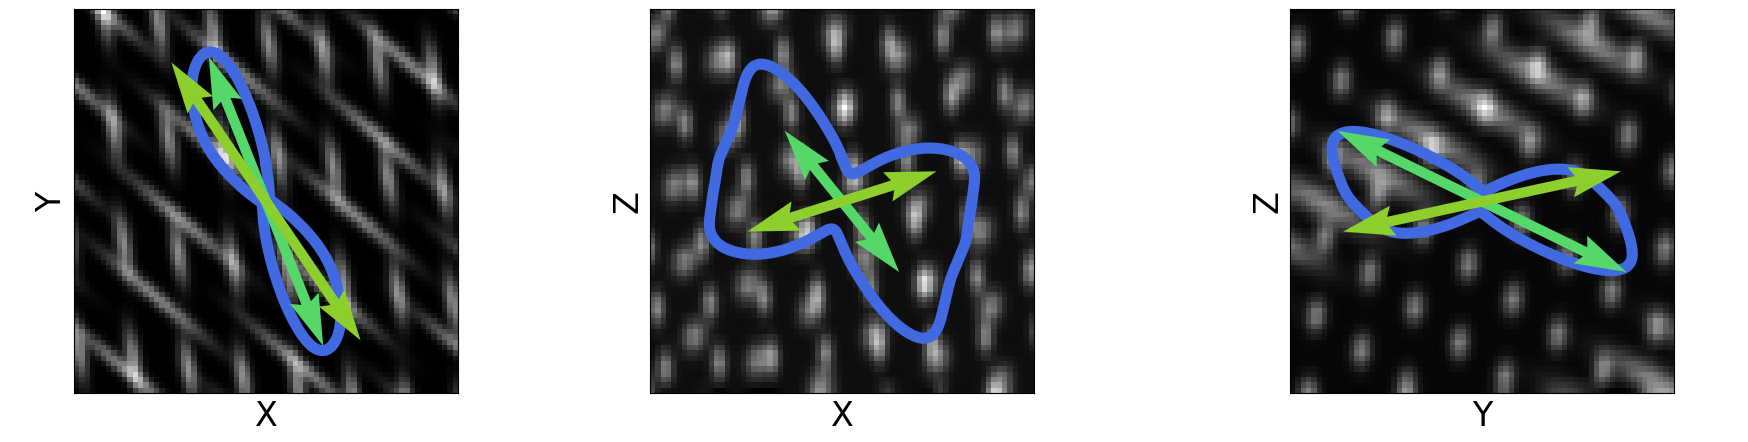

true angles: [[ 0.14053129  0.87844657  0.45670842]
 [ 0.74513817  0.62899307 -0.22166827]]
estimated angles: [[ 0.33512388  0.84648944  0.4136999 ]
 [ 0.55397485  0.81360753 -0.17650682]]
mean error (degrees): 13.538052467298849


In [7]:
I = image_iso_3d
sigma_g = 1.0 # gradient standard deviation
sigma_w = 2.0 # window standard deviation

# compute structure tensors given the phantom image and standard deviations
S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
# compute angles from structure tensors
angles = histology.angles(S, cartesian=True)
angles = angles.reshape(-1,3)

# convert true angles to cartesian coordinates for comparison with estimated angles
true_angles_ = utils.sph_to_cart(true_angles, order='xy')

true_angles_ = np.array([np.sin(true_angles[:,0])*np.sin(true_angles[:,1]),
                                np.sin(true_angles[:,0])*np.cos(true_angles[:,1]),
                                np.cos(true_angles[:,0])
                                ]).T

# Estimate 1 or 2 mean angles from estimated angles using k-means algorithm
if len(true_angles_) == 1:
    skm = apsym_kmeans.APSymKMeans(n_clusters=1)
    skm.fit(angles)
    means = skm.cluster_centers_
    # difference between estimated means and true angles (in degrees)
    diff = np.arccos(np.abs(means.dot(true_angles_.T))) * 180/np.pi 

elif len(true_angles_) == 2:
    skm = apsym_kmeans.APSymKMeans(n_clusters=2)
    skm.fit(angles)
    means = skm.cluster_centers_ # shape (n_clusters, n_features)

    diff_ = np.arccos(np.abs(means.dot(true_angles_.T)))
    diff_ = diff_.min()

    diff_ = np.empty((len(means),len(true_angles_))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(means)):
        for n in range(len(true_angles_)):
            diff_[m,n] = np.arccos(np.abs(means[m].dot(true_angles_[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi # mean error in degrees

histology.plot_angles_3d(I, vectors=angles, means=means)
# Note the arrows are colored according to their direction.
# The rgb color components are set to the absolute value of the xyz components:
# x=red, y=green, z=blue.

print(f'true angles: {true_angles_}')
print(f'estimated angles: {means}')
print(f'mean error (degrees): {diff}')

# Generate a 2D phantom

## Set the phantom parameters

In [8]:
# Choose two angles
true_angles = [np.pi/3, 0.0]

# or one angle
# true_angles = [np.pi/4]

# set the image dimensions
shape = (96,96)
dI = (shape[1]/shape[0], 1.0)
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# set the period (distance between parallel lines)
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

## Generate the phantom and do anisotropy correction

In [9]:
# generate phantom with anisotropic pixel sizes
image_2d = sta_validate.make_phantom(x, true_angles, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_2d = utils.anisotropy_correction(image_2d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_2d = utils.anisotropy_correction(image_2d, dI=dI, blur=True)

## Visualize

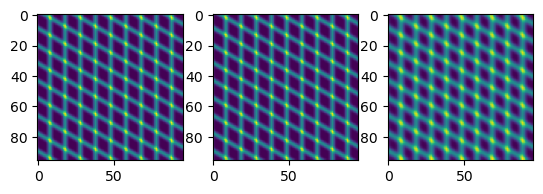

In [10]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_2d)
ax[1].imshow(image_iso_2d)
ax[2].imshow(image_iso_blur_2d)

# Perform structure tensor analysis on a 2D phantom

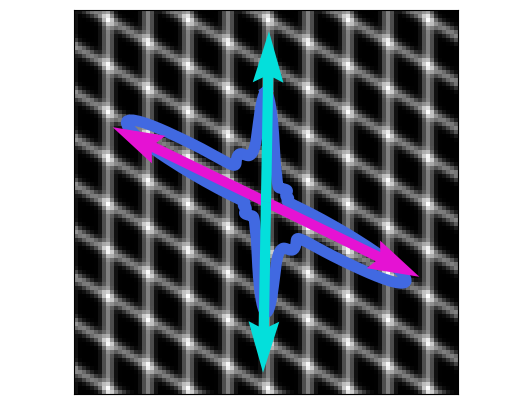

true angles: [1.0471975511965976, 0.0]
estimated angles: [1.11701072 3.12413936]
mean error (degrees): 2.499999999999997


In [13]:
I = image_iso_2d
sigma_g = 0.5 # gradient standard deviation
sigma_w = 0.0 # window standard deviation

# compute structure tensors given the phantom image and standard deviations
S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
# compute angles from structure tensors
angles = histology.angles(S)
angles = angles.flatten()#[..., None]
angles = np.where(angles < 0, angles + np.pi, angles) # flip angles to be in the range [0,pi] for periodic kmeans

# Estimate 1 or 2 mean angles from estimated angles using k-means algorithm
if len(true_angles) == 1:
    x = np.arange(180) * np.pi/180
    means = periodic_kmeans.periodic_mean(angles.flatten(), x, period=np.pi)[None]
elif len(true_angles) == 2:
    means = periodic_kmeans.periodic_kmeans(angles.flatten(), period=np.pi, k=2)

histology.plot_angles(I, angles=angles, means=means, colors=means)
# Note the arrows are colored according to their directions. 

print(f'true angles: {true_angles}')
print(f'estimated angles: {means}')

diff = periodic_kmeans.distance(means, np.array(true_angles), period=np.pi)
diff = diff.min(0) * 180/np.pi
error = np.mean(diff)

print(f'mean error (degrees): {error}')

## Compute ST analysis error in one line using sta_test

In [14]:
error = sta_validate.sta_test(image_iso_2d, derivative_sigma=sigma_g, tensor_sigma=sigma_w, true_thetas=true_angles)
print(error)

2.4999999999999973


## Run ST analysis tests on a series of phantoms

In [15]:
# Set lists for each parameter to use for generating phantoms and computing structure tensors
derivative_sigmas = np.linspace(start=0.5, stop=1.5, num=3) # standard deviations of first derivative filter
tensor_sigmas = np.linspace(start=1.0, stop=3.0, num=3) # standard devations of window averaging filter
nIs = [(96,96), (48,96), (32,96)] # Phantom shapes (number of pixels along each dimension)
periods=[10] # spacing between lines. 1 unit is equal to the size of a pixel in the high resolutin dimension.
angles=[[np.pi/3,-np.pi/6], [np.pi/3, 0.0], [np.pi/3, np.pi/6]] # List of pairs angles to use for phantom lines.

# Generate and test structure tensor analysis for each permutation of the parameters defined above.
error_df = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=nIs, periods=periods, angles=angles)

# The result is a pandas dataframe where each row is a structure tensor analysis test,
# and the parameters used for the test are in the columns.
# The last column is the resultant error using the given parameters.
print(error_df[:12])

  0%|          | 0/9 [00:00<?, ?it/s]

    derivative_sigma  tensor_sigma  anisotropy_ratio  period  \
0                0.5           1.0               1.0    10.0   
1                0.5           2.0               1.0    10.0   
2                0.5           3.0               1.0    10.0   
3                1.0           1.0               1.0    10.0   
4                1.0           2.0               1.0    10.0   
5                1.0           3.0               1.0    10.0   
6                1.5           1.0               1.0    10.0   
7                1.5           2.0               1.0    10.0   
8                1.5           3.0               1.0    10.0   
9                0.5           1.0               1.0    10.0   
10               0.5           2.0               1.0    10.0   
11               0.5           3.0               1.0    10.0   

                                       angles         error  
0   [1.0471975511965976, -0.5235987755982988]  6.361109e-15  
1   [1.0471975511965976, -0.523598775598298